In [13]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
import seaborn as sns
from dataloader import DataLoader
from PIL import Image
from _graphutils import GraphUtils
from _plotutils import PlotUtils
from kernels.wlkernel import WLKernel
from kernels.shortestpathkernel import ShortestPathKernel
from kernels.randomwalkkernel import RandomWalkKernel
from kernels.labelhasher import LabelHasher
from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.model_selection import LeaveOneOut
import networkx as nx

In [15]:
dl = DataLoader("../eyelink_data")
imgs = dl.get_example_images()

PLOT = {
    "aois": False,
    "scanpaths": False,
    "clustering": False,
    "matrices": False,
    "graphs": False,
    "kernel": True,
    "tsne": False,
    "mds": True,
    "loocv": True,
    "entropy": False
}

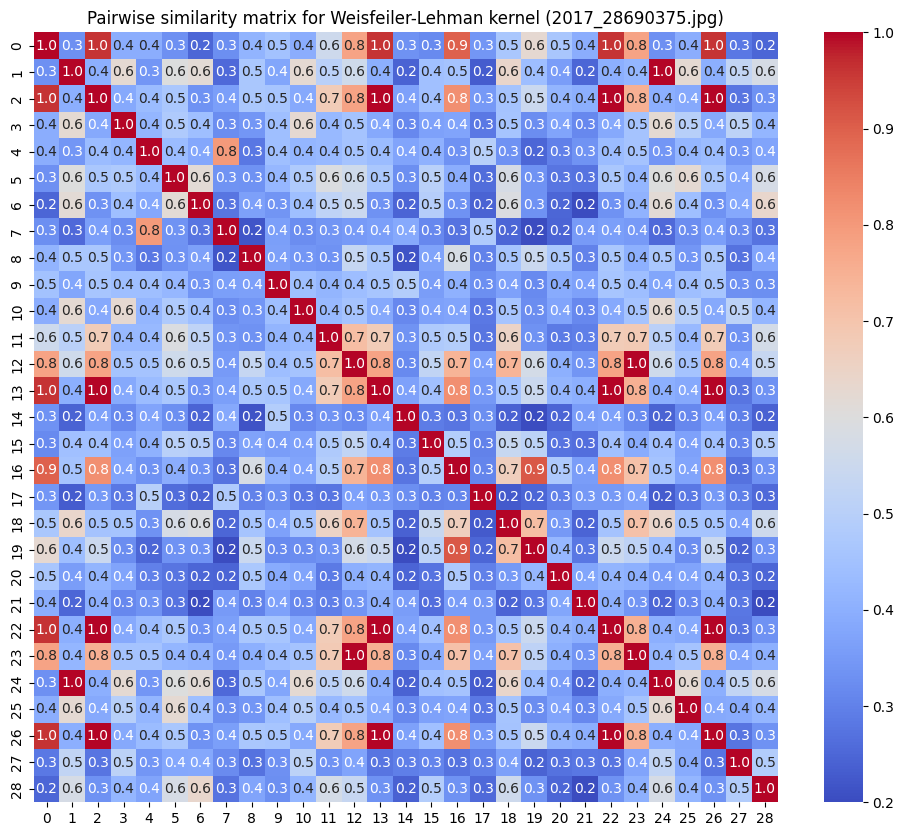

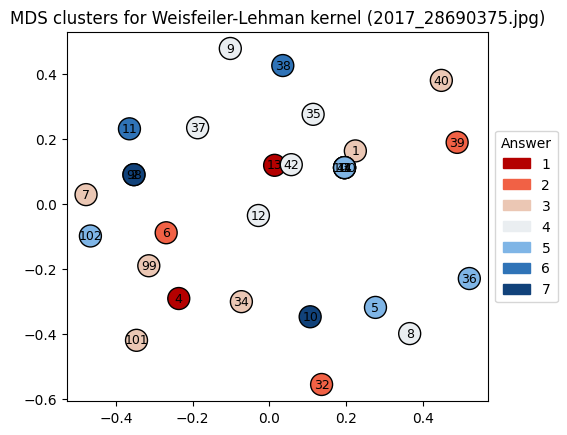

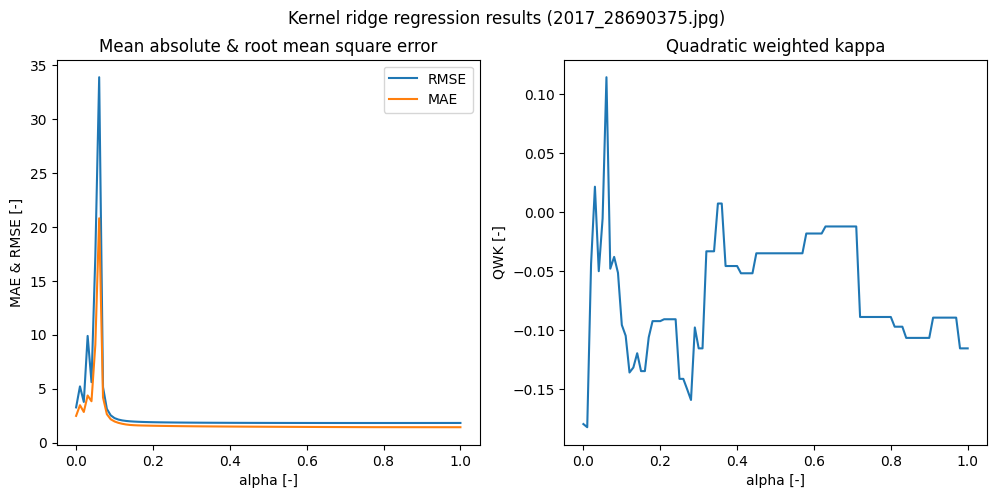

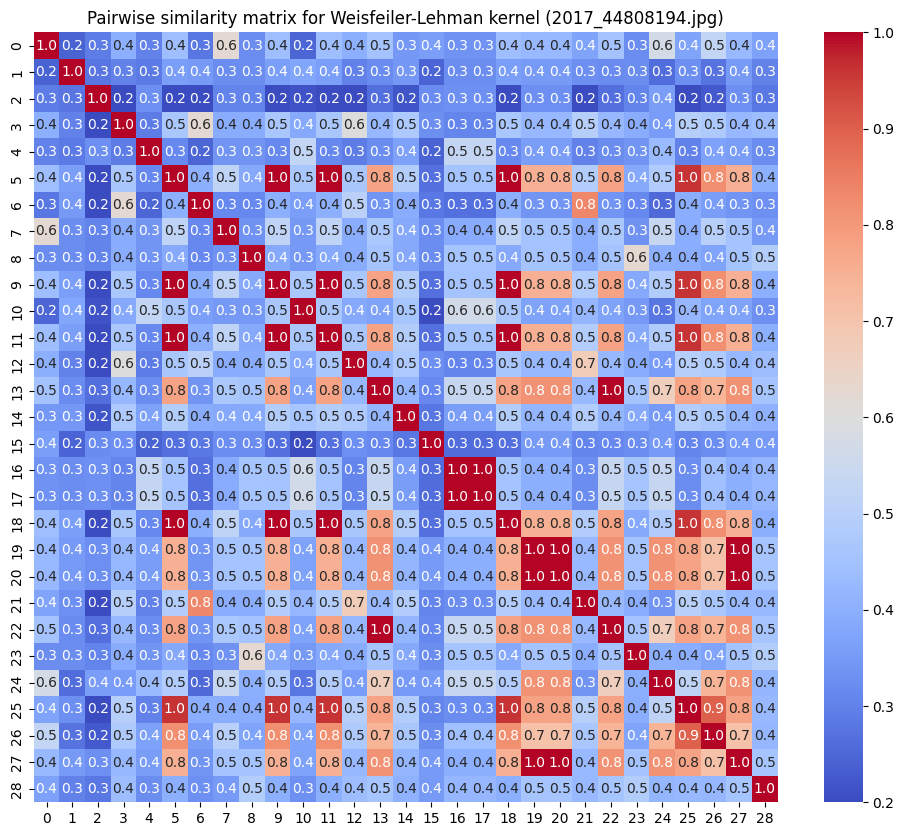

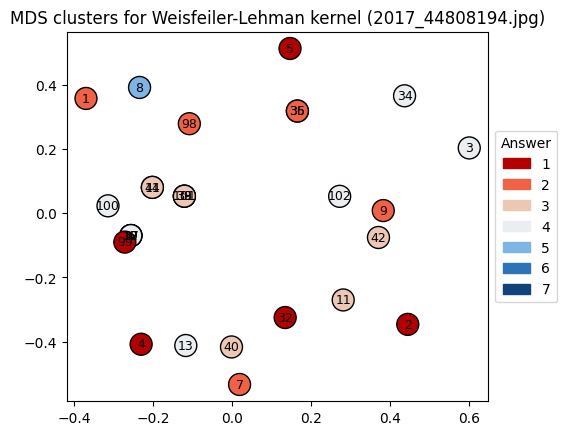

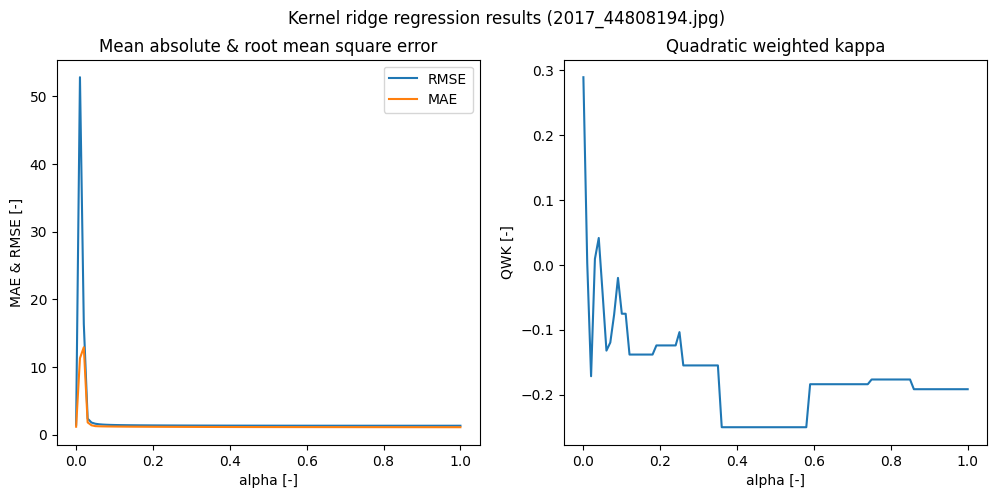

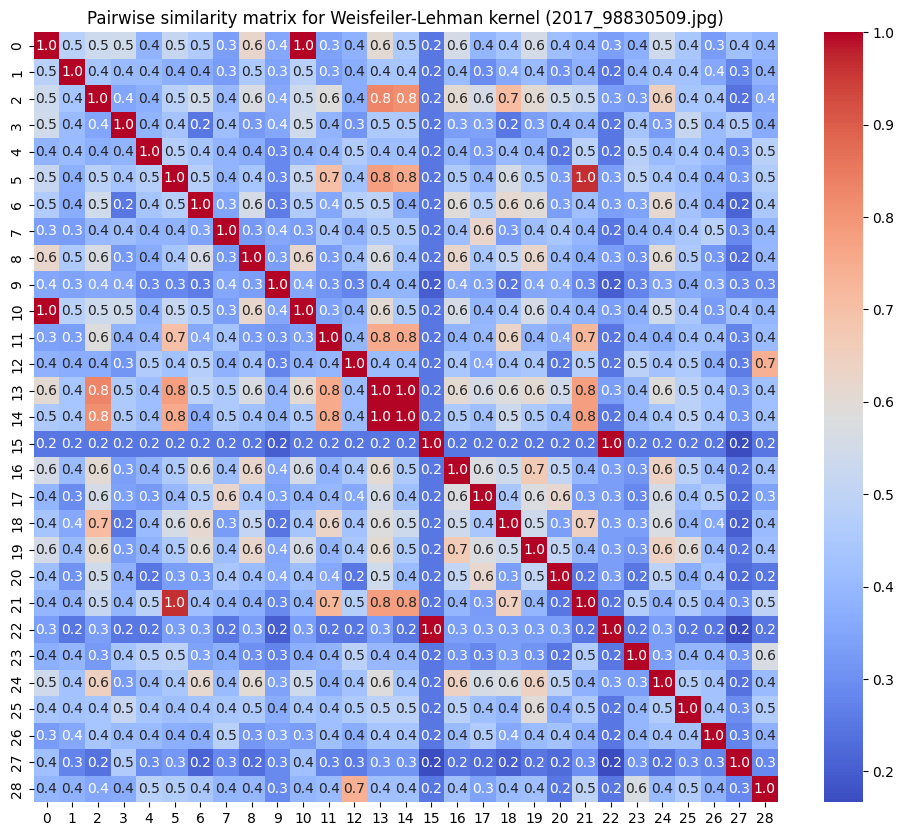

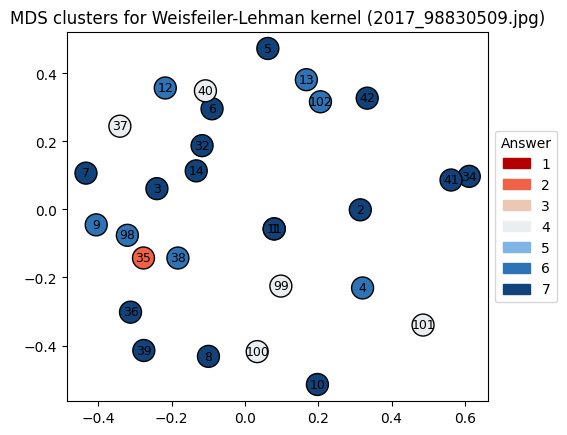

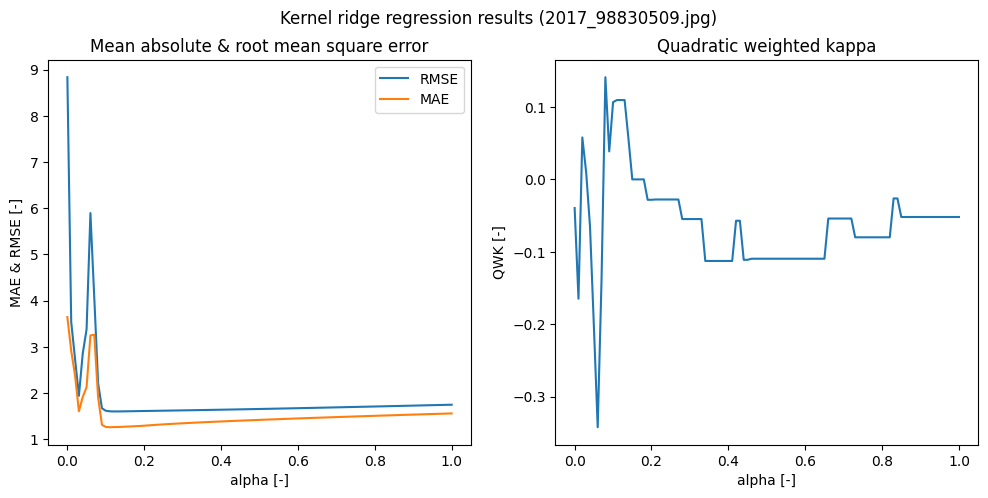

In [17]:
K_entropies = {}

for img in imgs:
    img_file = dl.get_image(img)
    aois = dl.get_image_aois(img)

    if PLOT["aois"]:
        PlotUtils.plot_aois(aois=aois, title="Original image and predefined AOIs", image=img_file)


    trials = dl.get_image_trials(img)
    trial_numbers = dl.get_image_trials(img, False)
    answer_dfs = dl.get_image_answers(img)
    answers = dl.get_image_ratings(img) 
    if PLOT["scanpaths"]:
        PlotUtils.wrap_dict_plot(trials, n_wrap=3, plotting_function=PlotUtils.trace_plot, title="Subject", image=img_file)


    MIN_CLUSTERS = 2
    MAX_CLUSTERS = 10

    trials_clustered: dict[int, pd.DataFrame] = {}
    cluster_centers: dict[int, dict[int, tuple[float, float]]] = {}
    for (subject, trial) in trials.items():
        df_clustered, intertia, cluster_c, k = GraphUtils.optimal_clustering(MIN_CLUSTERS, MAX_CLUSTERS, trial)
        trials_clustered[subject] = df_clustered
        cluster_centers[subject] = cluster_c

    if PLOT["clustering"]:
        PlotUtils.wrap_dict_plot(trials_clustered, n_wrap=3, plotting_function=PlotUtils.clustering_plot, title="Subject", image=img_file)


    # TRANSITION MATRCIES
    matrices = {subject: GraphUtils.transition_matrix(trial) for (subject, trial) in trials_clustered.items()}
    if PLOT["matrices"]:
        PlotUtils.wrap_dict_plot(matrices, n_wrap=3, plotting_function=PlotUtils.heatmap, title="Subject")


    # GRAPHS
    graphs = {subject: GraphUtils.transition_matrix_to_graph(matrix) for (subject, matrix) in matrices.items()}
    if PLOT["graphs"]:
        PlotUtils.wrap_dict_plot(graphs, n_wrap=3, plotting_function=PlotUtils.draw, title="Subject")


    # PRECOMPUTED KERNEL MATRIX
    subjects_order = list(matrices.keys())
    K_matrix = np.zeros(shape=(len(matrices), len(matrices)))
    for i, (subject1, G1) in enumerate(graphs.items()):
        for j, (subject2, G2) in enumerate(graphs.items()):

            G1_undirected = G1.to_undirected()
            G2_undirected = G2.to_undirected()
            h = 3
            try:
                d1 = nx.diameter(G1)
                d2 = nx.diameter(G2)
                h = max(d1, d2)
            except:
                largest_scc_1 = max(nx.strongly_connected_components(G1), key=len)
                d1 = nx.diameter(G1.subgraph(largest_scc_1))
                largest_scc_2 = max(nx.strongly_connected_components(G2), key=len)
                d2 = nx.diameter(G2.subgraph(largest_scc_2))
                h = max(d1, d2)
            wl = WLKernel(hasher=LabelHasher())
            v1 = wl.get_feature_vector(G1, refinement_steps=h)
            v2 = wl.get_feature_vector(G2, refinement_steps=h)
            K_matrix[i][j] = wl.get_kernel_value(v1, v2)

    if PLOT["kernel"]:
        PlotUtils.heatmap(K_matrix, title=f"Pairwise similarity matrix for Weisfeiler-Lehman kernel ({img})")


    D_matrix = 1 - K_matrix

    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
    X_2d_mds = mds.fit_transform(D_matrix)

    tsne = TSNE(n_components=2, perplexity=20, metric='precomputed', init="random", random_state=42)
    X_2d_tsne = tsne.fit_transform(D_matrix)

    labels = np.array(list(answers.values()))

    if PLOT["tsne"]:
        PlotUtils.dimensionality_reduction_plot(X_2d_tsne, title=f"t-SNE clusters for Weisfeiler-Lehman kernel ({img})", annotate=True, labels=answers)
    
    if PLOT["mds"]:
        PlotUtils.dimensionality_reduction_plot(X_2d_mds, title=f"MDS clusters for Weisfeiler-Lehman kernel ({img})", annotate=True, labels=answers)


    # LEAVE ONE OUT CROSS VALIDATION
    results = GraphUtils.loocv(K_matrix, answers)
    if PLOT["loocv"]:
        PlotUtils.loocv_plot(results, f"Kernel ridge regression results ({img})")
    
    K_entropy = GraphUtils.kernel_entropy(K_matrix)
    K_entropies[img] = K_entropy

if PLOT["entropy"]:
    fig, ax = plt.subplots(1, 1)
    fig.suptitle(f"Normalized entropy of pairwise kernel similarity matrices")
    ax.bar(x=[str(key) for key in K_entropies.keys()], height=K_entropies.values())
    ax.set(xlabel="Image [-]", ylabel="Normalized entropy [-]")
    ax.set_xticks(range(len(imgs)))           
    ax.set_xticklabels([str(key)[0:-4] for key in K_entropies.keys()], rotation=70, ha='right')  